# Image Reconstruction using Compressed Sensing

In this section, we explore how compressed sensing can be used to reconstruct images that have lost a large portion of their information.
The process is much the same as reconstruction of 1-dimensional images, with a few key differences.

First, we are still using the DCT to assume a sparse representation of the original signal.
Natural images are effectively sparse in the DCT domain; in fact, this is what normal JPEG compression uses to represent images.
Using this information, we can attempt to reconstruct natural images that have been randomly sampled at fairly low rates.

Python is not the best language to do heavy computation natively, but we can effectively show some examples at low resolutions.
For faster and more efficient processing, C libraries are often linked to or used directly to do the L-1 minimzation - the clear bottleneck for computing in this process.


### Importing libraries
First, we will import the necessary libraries. 
NumPy and matplotlib contain standard functions and data structures for dealing with arrays and for plotting.
From SciPy, we use the ndimage library to import images, and the fftpack library to access the DCT functions.
Finally, we import cvxpy in order to do our L-1 minimzation.

In [4]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack as spfft
import scipy.ndimage as spimg
import cvxpy as cvx

### 2-dimensional DCT
Next, we will define a few functions to more easily compute 2-dimensional DCTS in Python.

This is a common function, but scikit does not have multidimensional DCTs implemented explicitly, so these functions allow our code to be more readable.
Essentially, we just take the 1-dimensional DCT or inverse-DCT (IDCT) of all columns and rows of the 2-dimensional image:

In [5]:
def dct2(x):
    return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

def idct2(x):
    return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

### Image reading, lowering resolution, and sampling
Now, we will read in our image.
As mentioned previously, Python is a little slow for our computations, so we convert the image to greyscale and downsample it to reduce the resolution using the zoom function from scipy.ndimage.
This low-resolution image is then displayed using the imshow function from matplotlib:

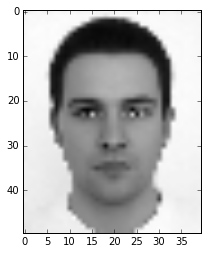

In [19]:
Iorig = spimg.imread('face.jpg', flatten=True, mode='L')
I = spimg.zoom(Iorig, 0.125)
plt.imshow(I, cmap = 'gray')
plt.show()

Now, we will randomly sample 50% of the image and display it.
This can be thought of as the original image being transmitted over an erasure channel.
The sampled image is then displayed; these pixels along with the assumption that the original image is sparse in the DCT domain are all that will be used in reconstruction.

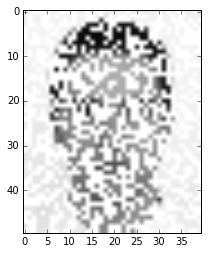

In [7]:
ny, nx = I.shape

#Calculate number of samples needed
samples = round(nx * ny * 0.50)

#Choose random indices and create a mask to apply to the original image
randi = np.random.choice(nx * ny, samples, replace=False)
b = I.T.flat[randi]
b = np.expand_dims(b, axis=1)
mask = np.zeros(I.shape)
mask.T.flat[randi] = 255

#Apply the mask and display "transmitted" image
Isampled = 255 * np.ones(I.shape)
Isampled.T.flat[randi] = I.T.flat[randi]
plt.imshow(Isampled, cmap = 'gray')
plt.show()

### Creating the A matrix
Here we use the Kronecker function from NumPy to create a DCT matrix for the image.
The Kronecker function produces the Kronecker product of two matrices.
In order to represent the inverse discrete cosine transform as a matrix multiplication, the Kronecker product of the inverse DCT of two identity matrices (one of the size of the width of the image, and one of the size of the height) is taken.

Intuitively, this matrix can be multiplied by a representation of an image in the DCT domain to transform it back to the spatial domain.
By only taking those rows corresponding to the pixels that were sampled, we have our A matrix, which incorporates the inverse transform as well as the random sampling.

This A matrix is used in our constrained optimization; any potential sparse representation must multiply by this A to obtain the original samples.

In [8]:
A = np.kron(
    spfft.idct(np.identity(nx), norm='ortho', axis=0),
    spfft.idct(np.identity(ny), norm='ortho', axis=0)
    )
A = A[randi,:]

### L-1 minimization
Next we peform our L-1 optimization.
This optimization is looking for the solution to Ax=b with the smallest L-1 norm for x, where A is the previously generated inverse transform/sampling matrix, and b is the vector of random samples from the original signal.

Intuitively, this is looking for a possible signal in the DCT domain which, when transformed back to the spatial domain, would yield our sampled pixel values. 
Since we know the signal should be sparse in the DCT domain, we are minimizing the L-1 norm in that domain.

In code, we first create a cvxpy variable of the proper size.
Next, we set our objective for the optimization; in this case it is to minimize the L-1 norm of the cvxpy variable.
We then set our previously mentioned constraint of matching the original samples exactly.
The optimization is then run, and the solution in the DCT domain is plotted.


ECOS 2.0.4 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  +6.382e-21  +8e+06  1e+00  1e-02  1e+00  2e+03    ---    ---    1  1  - |  -  - 
 1  +9.286e+03  +9.446e+03  +3e+06  9e-01  5e-03  2e+02  8e+02  0.6531  1e-01   1  0  1 |  0  0
 2  +1.374e+04  +1.379e+04  +7e+05  6e-01  1e-03  5e+01  2e+02  0.8103  3e-02   1  0  1 |  0  0
 3  +2.288e+04  +2.290e+04  +2e+05  2e-01  3e-04  2e+01  5e+01  0.7365  3e-02   1  0  0 |  0  0
 4  +3.262e+04  +3.262e+04  +6e+04  7e-02  9e-05  6e+00  2e+01  0.7010  3e-02   1  0  0 |  0  0
 5  +3.945e+04  +3.945e+04  +2e+04  2e-02  3e-05  2e+00  6e+00  0.6833  5e-02   1  1  1 |  0  0
 6  +4.261e+04  +4.261e+04  +8e+03  9e-03  1e-05  1e+00  2e+00  0.6841  7e-02   1  1  1 |  0  0
 7  +4.377e+04  +4.377e+04  +3e+03  3e-03  4e-06  4e-01  8e-01  0.6664  7e-02   1  1  1 |  0  0
 8  +4.419e+04  +4.419e+04  +1e+03  1e-03  2e-

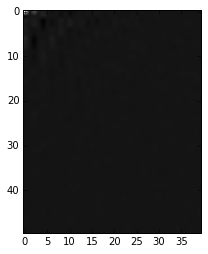

In [9]:
vx = cvx.Variable(nx * ny)
objective = cvx.Minimize(cvx.norm(vx, 1))
constraints = [A*vx == b]
prob = cvx.Problem(objective, constraints)
result = prob.solve(verbose=True)
Iat2 = np.array(vx.value).squeeze()

Iat = Iat2.reshape(nx, ny).T

plt.imshow(Iat, cmap = 'gray')
plt.show()

### Image recovery
The printout shown is the verbose output of the convex optimizer.
Essentially, you can see that about 20 iterations were needed to converge to an optimal solution.

The plot is being represented in greyscale, so the darker the pixel, the lower the value is.
Clearly, this image is mostly black, meaning that most values are 0 - the definition of sparsity.

Now, we simply peform an inverse DCT on these coefficients, using the previously defined 2-D IDCT, to attempt to recover our our original image.
This recovered image is then plotted for evaluation.

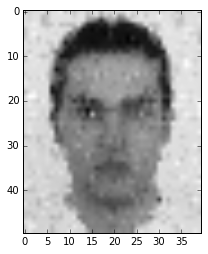

In [11]:
Ia = idct2(Iat)
plt.imshow(Ia, cmap = 'gray')
plt.show()

### Explanation of results and L-1 comparison
The results of this low-resolution experiment are passable, but not exciting; the image has clearly not been perfectly reconstructed.

Our main reason for this is the downsampling that we started with.
We know that natural images are sparse in the DCT domain, but since we were trying to save computation time, we heavily downsampled our image.
As a result, the image we operated on was much less sparse in the DCT domain, as it could no longer be considered a truly natural image.
Thus, our implicit assumption of sparsity was less solid than if we had used the original image.

To verify this as a potential cause, we can calculate the L-1 norm of the DCT of the original downsampled image, and the reconstructed image, as well as of the original full-resolution image:

In [27]:
ImDCT = dct2(I)
print('Original L-1:')
print(np.linalg.norm(np.reshape(ImDCT, (-1, 1)), 1)/len(np.reshape(ImDCT, (-1, 1))))

print('Reconstructed L-1:')
print(np.linalg.norm(np.reshape(Iat, (-1, 1)), 1)/len(np.reshape(Iat, (-1, 1))))

print('Full resolution L-1:')
ImFRDCT = dct2(Iorig)
print(np.linalg.norm(np.reshape(ImFRDCT, (-1, 1)))/len(np.reshape(ImFRDCT, (-1, 1))))


Original L-1:
29.255484375
Reconstructed L-1:
22.2425574969
Full resolution L-1:
0.502104919434


A few things become clear from looking at these L-1 norms.

First, the optimizer found a more sparse solution in the DCT domain than the original signal; this means that the results are not the fault of the L-1 minimzation.
Next, we can see that the original, full resolution image has a far lower L-1 norm in the DCT domain than either of the low-resolution images.
This matches our initial explanation that the lackluster results are due to the original downsampling in some way violating the assumption of sparsity.

### Higher-resolution results
It is clear that in order to obtain more impressive results, a higher resolution image must be used for the original sampling.
However, as previously mentioned, this process is not fast in Python.
So, examples at higher resolutions were performed offline and are here imported for viewing.
First, we show a series of images from an example done with L-1 minization and 50% sampling.
The first image is the original signal, the second is the sampled signal, the third is the reconstructed image, and the fourth is the DCT of the reconstructed image:

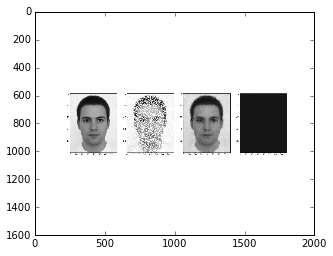

In [30]:
IL150 = spimg.imread('l1face50.png', flatten=True, mode='L')
plt.imshow(IL150, cmap = 'gray')
plt.show()


Next, we show the same example, but reconstructed using only 25% sampling:

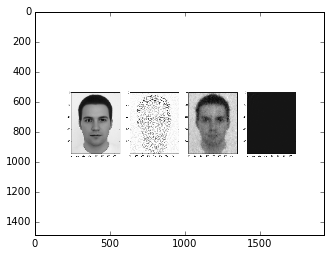

In [31]:
IL125 = spimg.imread('l1face25.png', flatten=True, mode='L')
plt.imshow(IL125, cmap = 'gray')
plt.show()

Finally, out of curiosity we performed reconstruction from the 50% sampled image using L-2 minimzation rather than L-1 minization:

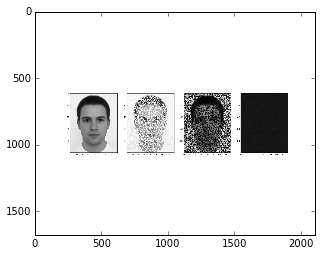

In [32]:
IL250 = spimg.imread('l2face50.png', flatten=True, mode='L')
plt.imshow(IL250, cmap = 'gray')
plt.show()

As you can see, the L-2 minization did not perform well for reconstruction.
It seems that the minimal L-2 norm of a solution to this problem yields 0 for every non-sampled pixel in the original image